# Required packages

In [1]:
#Required packages
import pandas as pd
import tensorflow as tf
import numpy as np
import time

# Create Dataset

In [2]:
#Load dataset from the text file
df = pd.read_csv('input.txt', sep='\t', header=None)

## Pre-processing

In [3]:
# Preprocess the text data: Tokenize and encode
def preprocess_text(text):
    #Create tokenizer object
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, oov_token='<UNK>')
    #Fit on text and convert sentences to sequences of numbers
    tokenizer.fit_on_texts([text])
    sequences = tokenizer.texts_to_sequences([text])[0]
    #Words and indices
    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    return sequences, word_index, index_word, tokenizer

# Create training data for auto-regressive decoder architecture
def create_training_sequences(sequences, seq_length):
    inputs = []
    targets = []
    #Create sequences and corresponding targets
    for i in range(len(sequences) - seq_length):
        inputs.append(sequences[i:i+seq_length])
        targets.append(sequences[i+1:i+seq_length+1])
    return np.array(inputs), np.array(targets)

In [4]:
#Preprocess text
sequences, word_index, index_word, tokenizer = preprocess_text(str(df.values))

#Total vocabulary
vocab_size = len(word_index) + 1  # Plus one for the OOV token
#Context length
seq_length = 20

#Input sequences and targets
inputs, targets = create_training_sequences(sequences, seq_length)

# Create TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

# Auto-regressive Decoder Design

In [5]:
class SimpleTransformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model):
        super(SimpleTransformer, self).__init__()
        #Input embeddings
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        #Positional encodings
        self.positional_encoding = self.get_positional_encoding(vocab_size, d_model)
        #Query, Key and Values
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        #Fully connected layer
        self.dense = tf.keras.layers.Dense(d_model)
        #Output layer
        self.output_dense = tf.keras.layers.Dense(vocab_size)
        
    #Create positional encodings using sines and cosines
    def get_positional_encoding(self, position, d_model):
        #Get angle values
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        #Sine for even and Cosine for odd positions
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        #Add extra dimension and return the tensor
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    #Positional encoding angles
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    #Causal masking of future tokens
    def create_causal_mask(self, seq_len):
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return mask[tf.newaxis, :, :]  #Extra dimension for batch size
    
    #Model forward pass
    def call(self, x):
        #Get context length
        seq_len = tf.shape(x)[1]
        
        #Embeddings and positional encodings
        x = self.embedding(x)
        x += self.positional_encoding[:, :seq_len, :]
        
        #Get the causal mask
        causal_mask = self.create_causal_mask(seq_len)
        
        #Calculate the Query, Key and Value matrices
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        
        #Calculate attention scores and normalize
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        #Apply causal masking
        if causal_mask is not None:
            scaled_attention_logits += (causal_mask * -1e9)
        
        #Apply softmax to attention scores
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        #Attention output and embedding transformation
        attention_output = tf.matmul(attention_weights, v)
        output = self.dense(attention_output)
        
        #Model output
        output = self.output_dense(output)
        return output

# Model Training

In [6]:
#Model dimension (embeddings)
d_model = 64
# Create the model
model = SimpleTransformer(vocab_size, d_model)
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
# Train the model
epochs = 200
history = model.fit(dataset, epochs=epochs)

Epoch 1/200
106/106 [==============================] - 2s 3ms/step - loss: 6.7109
Epoch 2/200
106/106 [==============================] - 0s 3ms/step - loss: 6.4511
Epoch 3/200
106/106 [==============================] - 0s 3ms/step - loss: 5.9486
Epoch 4/200
106/106 [==============================] - 0s 3ms/step - loss: 5.3786
Epoch 5/200
106/106 [==============================] - 0s 3ms/step - loss: 4.4835
Epoch 6/200
106/106 [==============================] - 0s 4ms/step - loss: 3.4323
Epoch 7/200
106/106 [==============================] - 0s 4ms/step - loss: 2.3878
Epoch 8/200
106/106 [==============================] - 0s 4ms/step - loss: 1.7606
Epoch 9/200
106/106 [==============================] - 0s 3ms/step - loss: 1.4735
Epoch 10/200
106/106 [==============================] - 0s 4ms/step - loss: 1.3150
Epoch 11/200
106/106 [==============================] - 0s 3ms/step - loss: 1.1711
Epoch 12/200
106/106 [==============================] - 0s 4ms/step - loss: 1.0732
Epoch 13/200


106/106 [==============================] - 0s 4ms/step - loss: 0.1443
Epoch 100/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1429
Epoch 101/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1424
Epoch 102/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1414
Epoch 103/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1416
Epoch 104/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1421
Epoch 105/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1427
Epoch 106/200
106/106 [==============================] - 0s 3ms/step - loss: 0.1415
Epoch 107/200
106/106 [==============================] - 0s 3ms/step - loss: 0.1394
Epoch 108/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1383
Epoch 109/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1376
Epoch 110/200
106/106 [==============================] - 0s 3ms/step - loss: 0.1391
Epoch 

106/106 [==============================] - 0s 4ms/step - loss: 0.1283
Epoch 197/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1227
Epoch 198/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1223
Epoch 199/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1218
Epoch 200/200
106/106 [==============================] - 0s 4ms/step - loss: 0.1214


# Generate Text

In [7]:
# Generate text from the model
def generate_text(model, tokenizer, seq_length, seed_text, num_words):
    #Iterate over the number of stokens to generate
    for _ in range(num_words):
        #Convert seed text to sequence of numbers
        tokenized_input = tokenizer.texts_to_sequences([seed_text])[0]
        #Convert to tensor and add extra batch dimension
        tokenized_input = tf.constant(tokenized_input[-seq_length:])[tf.newaxis, :]
        #Prediction from the model
        predictions = model(tokenized_input)
        #Pick the token with highest probability
        predicted_id = tf.argmax(predictions[0, -1, :]).numpy()
        #Append get word from the index and add it to the generated text
        seed_text += ' ' + tokenizer.index_word.get(predicted_id)
    return seed_text

# Provide seed Textrr
seed_text = "اسکا اختتام مسور کی طپف سے بیت ڈھارہا ہوں"
#Text generation
generated_text = generate_text(model, tokenizer, seq_length, seed_text, num_words=100)
generated_text = generated_text.replace('[', '').replace(']', '').replace("'", '')

#Print the generated text
for line in generated_text.splitlines():
  words = line.split()
  for word in words:
    print(word, end=" ")
    time.sleep(0.15)
  print()

اسکا اختتام مسور کی طپف سے بیت ڈھارہا ہوں اکثر بیمار یارا 
آ گیا تھا وہ خوش خصال پسند 
تھی ہماری بھی کیا کمال پسند 
حیف! بد صورتی رویّوں کی 
ہائے دل تھا مرا جمال پسند 
کیوں بنایا تھا ٹِھیکرا دل کو 
کیوں کیا ساغرِ سفال پسند 
ٹھیک ہے میں نہیں پسند اُنہیں 
لیکن اس درجہ پائمال پسند 
سچ نہ کہیے کہ سچ ہے صبر طلب 
لوگ ہوتے ہیں اشتعال پسند 
ہاں مجھے آج بھی پسند ہے وہ 
اس کو کہتے ہیں لازوال پسند 
حلم ہے اہلِ علم کا شیوہ 
جاہ والوں کو ہے جلال پسند 
وصل کو ہجر ، ناگہانی موت 
ہجر کو موسمِ وصال پسند 
فکرِ دنیا 


# Model Details
## Architecture

In [8]:
#Model summary
model.summary()

Model: "simple_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  95616     
_________________________________________________________________
dense (Dense)                multiple                  4160      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  4160      
_________________________________________________________________
dense_3 (Dense)              multiple                  4160      
_________________________________________________________________
dense_4 (Dense)              multiple                  97110     
Total params: 209,366
Trainable params: 209,366
Non-trainable params: 0
__________________________________________

## Learning curve

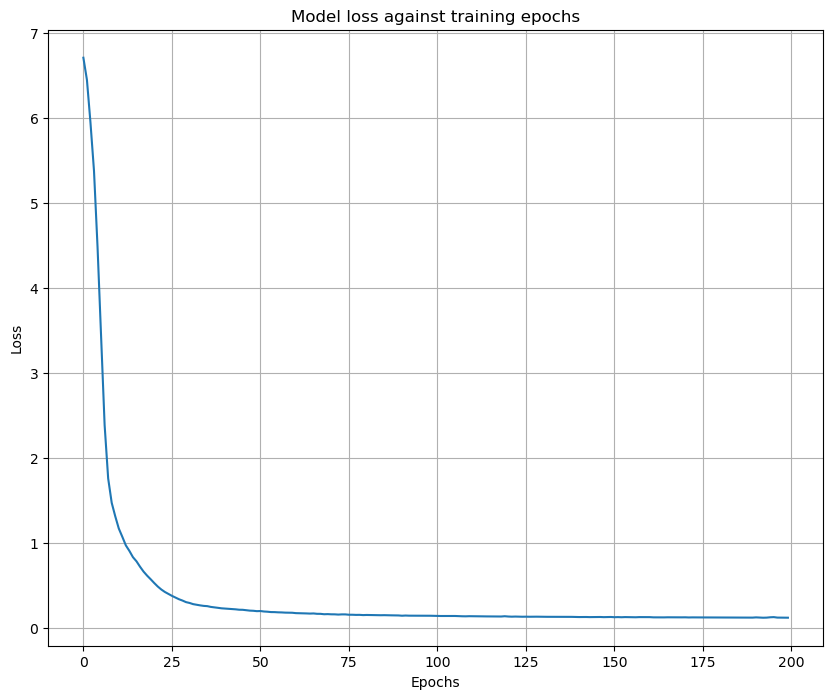

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8),dpi=100)
plt.plot(range(epochs), history.history['loss'])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model loss against training epochs");